In [1]:
import sys, os
import pickle
from dotenv import load_dotenv
load_dotenv()

import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import osmnx as ox
import shapely

import cvxpy as cp

import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio
from scipy.stats import poisson, uniform

from sodapy import Socrata

import plotly.express as px

(CVXPY) Nov 29 02:20:56 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <EA245032-41C7-30EA-BA1A-C55492696949> /Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so\n  Reason: tried: '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/bin/../lib/liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in d

In [2]:
APP_TOKEN = os.getenv("APP_TOKEN")
client = Socrata("data.cityofnewyork.us", APP_TOKEN, timeout=3600)

# Parking Simulation: Chelsea

## Chelsea Network
Extract NetworkX Directed Graph from a geojson polygon using OSMNX

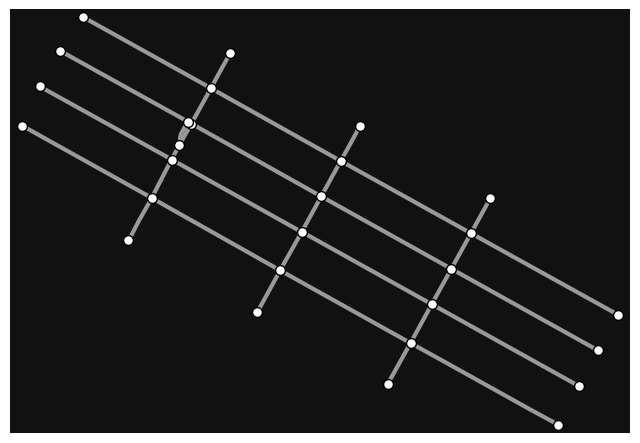

In [3]:
# Get shaply value from geojson
polygon = gpd.read_file('chelsea_network.geojson').to_crs(4326)['geometry'][0]

# Create graph from Open Street Map based on graph, Include travel time over edges
G = ox.add_edge_travel_times(ox.add_edge_speeds(ox.graph_from_polygon(polygon, network_type='drive', simplify=True)))

## The current method of just using osmnx to get the lines is not granular enough so we need to refilter the graph with gpd
# Creates dataframes based on nodes and edges
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Remove edges outside of polygon
gdf_edges = gdf_edges[gdf_edges.geometry.within(polygon) == True]

# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

fig, ax = ox.plot_graph(G, node_color="w", node_edgecolor="k", node_size=50, edge_linewidth=3)

In [4]:
# convert MultiDiGraph to DiGraph
# choose between parallel edges by minimizing travel_time attribute value
D = ox.get_digraph(G, weight='travel_time')
# For directed graphs, entry i,j corresponds to an edge from i to j.
A = nx.adjacency_matrix(D, nodelist=list(D.nodes)).todense()
# The incidence matrix assigns each row to a node and each column to an edge.
# -1: the source (tail) of an edge
# 1: the destination (head) of the edge
M = nx.incidence_matrix(D, nodelist=list(D.nodes), edgelist=list(D.edges), oriented=True).todense()

# Dual graph
D_prime=nx.line_graph(D)
# Note: this is the adjacency matrix for the DUAL graph
A_prime = nx.adjacency_matrix(D_prime, nodelist=list(D.edges)).todense()
L_prime = nx.directed_laplacian_matrix(D_prime, nodelist=list(D.edges))

## Simulations

### Parking Volumes

Heuristic for estimating number of parked cars should include:
- Reduction for length/width of an intersection
    - Length of an intersection adjacent to an avenue (110 ft. => ~6m)
    - Length of an intersection adjacent to a street (60 ft. =>)
- Reduction for curb cuts and fire hydrants (driveways etc. etc.)
    - **Assumption**: 1 reduction per edge ~15m
- Average length of a parking space (20 feet ~6m)

In [5]:
T = 500

In [6]:
# create parking matrix
def generate_parking_matrix(edges, T, reduction=0.2, car_length=6, mean_state=0.9):
    '''
    Simulates the number of parked cars on each edge by sampling from a poisson distribution
    with logical bounds for max parking capacity on the block.
    
    reduction : float
        reduction in available space on each edge, based on assumption there are fire hydrants, driveways, etc (percentage)
    car_length : int
        assumed length of a parking space (in meters)
    mean_state : float
        percentage of block full on average (assumes default 90%) 
    '''
    parking_df = edges.copy()
    
    # calculate number of parking spaces per block (on each edge)
    parking_df['parking_spaces'] = round(parking_df['length']*(1-reduction) / car_length ) 
    parking_df = parking_df[['parking_spaces']].droplevel('key')

    parking_df['mean_parking'] = parking_df['parking_spaces'] * mean_state

    # calculate parking state at each time interval
    for time in range(T):
        col = 'parking_at_'+str(time)
        # Given parking_df['mean_parking] (the average number of parked cars on a block),
        # what is the probability that the number of parked cars is less than or equal
        # to parking-df['parking_spaces] (the max parking spaces on a block)
        cutoff = poisson.cdf(parking_df['parking_spaces'], parking_df['mean_parking']) 
        # generate uniform distribution [0, cutoff):
        # uniform assumes there is an equal liklihood of getting something between 0 and cutoff value
        u = uniform.rvs(scale=cutoff, size=len(parking_df)) 
        # convert to Poisson:
        parking_df[col] = poisson.ppf(u, parking_df['mean_parking']) # ppf is inverse of cdf

    return parking_df

In [7]:
np.random.seed(42)
P = generate_parking_matrix(edges=gdf_edges, T=T)
P = P.loc[list(D.edges), :].iloc[:, 2:].to_numpy()
P.shape

(34, 500)

### Inflow / Outflow

#### Formulation

**Variables**:
- $G(V,E)$ is a network (graph) where the nodes/vertices ($V$) represent road intersections and the links/edges ($E$) represent the street segments.
- $P(u, v, t)$: Number of vehicles parked on road segment / edge $(u, v)$ at time $t$ (start of the time interval).

**Decision Variables**:
- $F_{\text{in}}(u, v, t)$: Number of vehicles flowing into edge $(u, v)$ over time interval starting at $t$.
- $F_{\text{out}}(u, v, t)$: Number of vehicles flowing out of edge $(u, v)$ over time interval starting at $t$.

**Objective Function**: Most terms are borrowed from the matrix completion objective function (perhaps it's problematic / circular reasoning to use similar elements to the original objective function):

$$
\begin{align}
\text{minimize } \lambda_1||F_{\text{in}}^{\intercal}L'F_{\text{out}}||_F \\
+ \lambda_2||F_{\text{out}}^{\intercal}L'F_{\text{in}}||_F \\
+ \lambda_3||F_{\text{in}}(:, t+1) - F_{\text{in}}(:, t)||_F \\
+ \lambda_4||F_{\text{out}}(:, t+1) - F_{\text{out}}(:, t)||_F \\
+ \lambda_5||F_{\text{in}} - F_{\text{out}}||_F
\end{align}
$$

**Constraints**:
1. **Parking Change Consistency**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}(u, v, t) - F_{\text{out}}(u, v, t) = P(u, v, t+1) - P(u, v, t) = \delta P(u, v, t)
$$

2. **Flow Conservation** (around *interior* intersections):

For each edge $(u, v)$ and time interval starting at $t$: the inflow into an edge $(u, v)$ over time interval starting at $t$ must be equal to the sum of outflow from edges incident on the origin $u$ (i.e., edges **going into** intersection $u$), minus the sum of inflow into other edges that share the same origin $u$ (but **different** $v$) over that same interval.

$$
F_{\text{in}}(u, v, t) = \sum_{\forall w \text{; } \exists (w, u) \in E} F_{\text{out}}(w, u, t) - \sum_{\forall w \text{; } \exists (u, w) \in E \text{; } w \neq v} F_{\text{in}}(u, w, t)
$$

$$
F_{\text{in}}(:, t) = A'^\intercal \cdot F_{\text{out}}(:, t) - O \cdot F_{\text{in}}(:, t)
$$
- Where $O$ is an "outgoing" matrix constructed from the incidence matrix $M$ that indicates for each edge $(u, v)$, all the ***other*** edges that share the same origin $u$.
- This balance can only be applied to edges for which the origin is fully characterized (i.e., we know all the connected edges to that origin). Therefore, it cannot be applied to the outer edges on the boundaries of the network that are "sources" of flow into the whole network.

3. **Non-negativity**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}(u, v, t) \geq 0, \quad F_{\text{out}}(u, v, t) \geq 0
$$

4. **Integer Constraints**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}(u, v, t) \in \mathbb{Z}, \quad F_{\text{out}}(u, v, t) \in \mathbb{Z}
$$

#### Set-up

In [8]:
# Let's construct O: 
M_in = np.where(M == -1, 1, 0)

# For each edge in M (columns), identify the node where the edge originates from,
# and then append the row of all other edges that share the same origin node
O = []
for e in M_in.T:
    idx = np.argmax(e)
    O.append(M_in[idx])
O = np.array(O)
# subtract the identity matrix to ensure that the edge itself is not counted in its outflow.
O = O - np.eye(len(D.edges), len(D.edges))

the flow conservation constraint can only be applied to edges for which the origin is fully characterized (i.e., we know all the connected edges to that origin). In practice, we shall construct a binary "mask" that zeroes out rows pertaining to edges that shouldn't be included in this constraint:

In [9]:
mask = np.ones_like(P)
for idx, e in enumerate(D.edges):
    if len(D.in_edges(e[0])) == 0:
        mask[idx, :] = 0

#### Gurobi Solver

In [10]:
%%time

# Decision Variables
F_in = cp.Variable((len(D.edges), T))#, integer=True)
F_out = cp.Variable((len(D.edges), T))#, integer=True)

# Hyperparameters
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1

# expr1 = l1 * cp.atoms.norm(F_in.T @ L_prime @ F_out, p='fro')
# expr2 = l2 * cp.atoms.norm(F_out.T @ L_prime @ F_in, p='fro')
expr3 = l3 * cp.atoms.norm(F_out[:, 1:] - F_out[:, :-1], p='fro')
expr4 = l4 * cp.atoms.norm(F_in[:, 1:] - F_in[:, :-1], p='fro')
expr5 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

# Objective
objective = cp.Minimize(expr3 + expr4 + expr5)

# Constraints
constraints = [
    F_in >= 0,  # Ensure each element of F_in is positive
    F_out >= 0  # Ensure each element of F_out is positive    
]

# Parking Change Consistency
constraints.append((F_in - F_out)[:, :-1] == (P[:, 1:] - P[:, :-1]))

# Flow Conservation
constraints.append(cp.multiply(mask, F_in) == cp.multiply(mask, A_prime.T @ F_out - O @ F_in))

# Formulating the problem
problem = cp.Problem(objective, constraints)

problem.solve(solver=cp.GUROBI, reoptimize=False)

problem.status

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-10
CPU times: user 9.54 s, sys: 3.4 s, total: 12.9 s
Wall time: 2.71 s


'optimal'

## Sense Checks
Let's demonstrate how the constraints are manifested in results:

In [11]:
P = pd.DataFrame(P, index=D.edges).round(0).astype(int)
F_in = pd.DataFrame(F_in.value, index=D.edges).round(0).astype(int)
F_out = pd.DataFrame(F_out.value, index=D.edges).round(0).astype(int)

test_data = {'D': D, 'L_prime': L_prime, 'A_prime': A_prime,
             'O': O, 'mask': mask,
             'P': P, 'F_in': F_in, 'F_out':F_out}
pickle.dump(test_data, open('test_data_v1.pkl', 'wb'))

$$
F_{\text{in}}(u, v, t) - F_{\text{out}}(u, v, t) = P(u, v, t+1) - P(u, v, t) = \delta P(u, v, t)
$$

$$
P(u, v, t) + F_{\text{in}}(u, v, t) - F_{\text{out}}(u, v, t) = P(u, v, t+1)
$$

In [12]:
((F_in.values - F_out.values)[:, :-1] == P.values[:, 1:] - P.values[:, :-1]).all()

True

$$
F_{\text{in}}(u, v, t) = \sum_{\forall w \text{; } \exists (w, u) \in E} F_{\text{out}}(w, u, t) - \sum_{\forall w \text{; } \exists (u, w) \in E \text{; } w \neq v} F_{\text{in}}(u, w, t)
$$

In [13]:
(mask * F_in.values == A_prime.T @ F_out.values - O @ F_in.values)

array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True, False,  True, ..., False,  True, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [14]:
np.linalg.norm((mask * F_in.values) - (A_prime.T @ F_out.values - O @ F_in.values), ord='fro')

66.31741852635702